In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns
import pydicom
import time
import gc
import operator 
from apex import amp 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
from skimage.io import imread,imshow
from helper import *
from apex import amp
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *
import pretrainedmodels
from pytorchcv.model_provider import get_model as ptcv_get_model

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 43564
device=device_by_name("Tesla")
#device=device_by_name("RTX")
#device = "cpu"

In [3]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [4]:
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)

In [5]:
np.random.seed(SEED)
split = train_df.SeriesI.unique()
np.random.shuffle(split)
split_train=split[:int(0.9*split.shape[0])]
split_val=split[int(0.9*split.shape[0]):]

idx_train = train_df[train_df.SeriesI.isin(set(split_train))].index.values
idx_validate = train_df[train_df.SeriesI.isin(set(split_val))].index.values
idx_train.shape
idx_validate.shape

(607241,)

(67263,)

In [6]:
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)

In [7]:
def my_loss(y_pred,y_true,weights):
    loss = F.binary_cross_entropy_with_logits(y_pred,y_true,weights.repeat(y_pred.shape[0],1))
    if torch.isnan(loss)!=0:
        print (y_pred)
        print (y_true)
        print (weights)
        loss = 0
    return loss

In [8]:
def get_optimizer_parameters(model,klr):
    zero_layer=['init_block']
    param_optimizer = list(model.named_parameters())
    num_blocks=5
    no_decay=['bias']
    optimizer_grouped_parameters=[
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and any(nd in n for nd in zero_layer))], 'lr':klr*0.5e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and any(nd in n for nd in zero_layer)], 'lr':klr*0.5e-5, 'weight_decay': 0.0}
        ]
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
        ])
    for i in range(num_blocks):
        optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('stage{}'.format(i+1) in n))], 'lr':klr*(2.0**i)*0.5e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('stage{}'.format(i+1) in n)], 'lr':klr*(2.0**i)*0.5e-5, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('final_block' in n))], 'lr':klr*1e-4,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('final_block' in n)], 'lr':klr*1e-4, 'weight_decay': 0.0}
        ])
    #print (optimizer_grouped_parameters)
    return(optimizer_grouped_parameters)

In [9]:
class parameter_scheduler():
    def __init__(self,model,do_first=['classifier'],num_epoch=1):
        self.model=model
        self.do_first = do_first
        self.num_epoch=num_epoch
    def __call__(self,epoch):
        if epoch>=self.num_epoch:
            for n,p in self.model.named_parameters():
                p.requires_grad=True
        else:
            for n,p in self.model.named_parameters():
                p.requires_grad= any(nd in n for nd in self.do_first)


{'loss': 0.44031238115958815, 'val_loss': 0.2953250281435653}


{'loss': 0.14579345114848333, 'val_loss': 0.11582905512776251}

0.11582905512776251


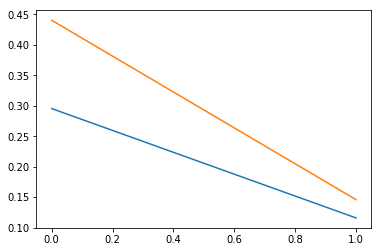

In [10]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=24
num_workers=12
num_epochs=2
model_name,version = 'efficientnet_5b5' , 'basic1'
model = MyEfficientNet(ptcv_get_model("efficientnet_b5b", pretrained=True),len(hemorrhage_types))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=model.parameter_scheduler,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling)

plt.plot(np.array([[hist['val_loss'] for hist in history],[hist['loss'] for hist in history]]).transpose())

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))


In [10]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=24
num_workers=12
num_epochs=5
model_name,version = 'efficientnet_5b5' , 'classifier'
model = MyEfficientNet(ptcv_get_model("efficientnet_b5b", pretrained=True),len(hemorrhage_types),dropout=0.5)
#model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic1',num_split),map_location=torch.device(device)))
_=model.to(device)
param_s=parameter_scheduler(model,num_epoch=1)        
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.1,rotate=20,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[0.2,0.2,0.2,0.2,0.2,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=param_s,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

{'loss': 0.23441222642016246, 'val_loss': 0.21233150810986767}


{'loss': 0.1141735008609346, 'val_loss': 0.11228354551965292}


{'loss': 0.09385163455910876, 'val_loss': 0.10149738830628882}


{'loss': 0.08192155774077196, 'val_loss': 0.09525606077211925}


{'loss': 0.08243785139628121, 'val_loss': 0.09374659490051254}

0.09374659490051254


<IPython.core.display.Javascript object>


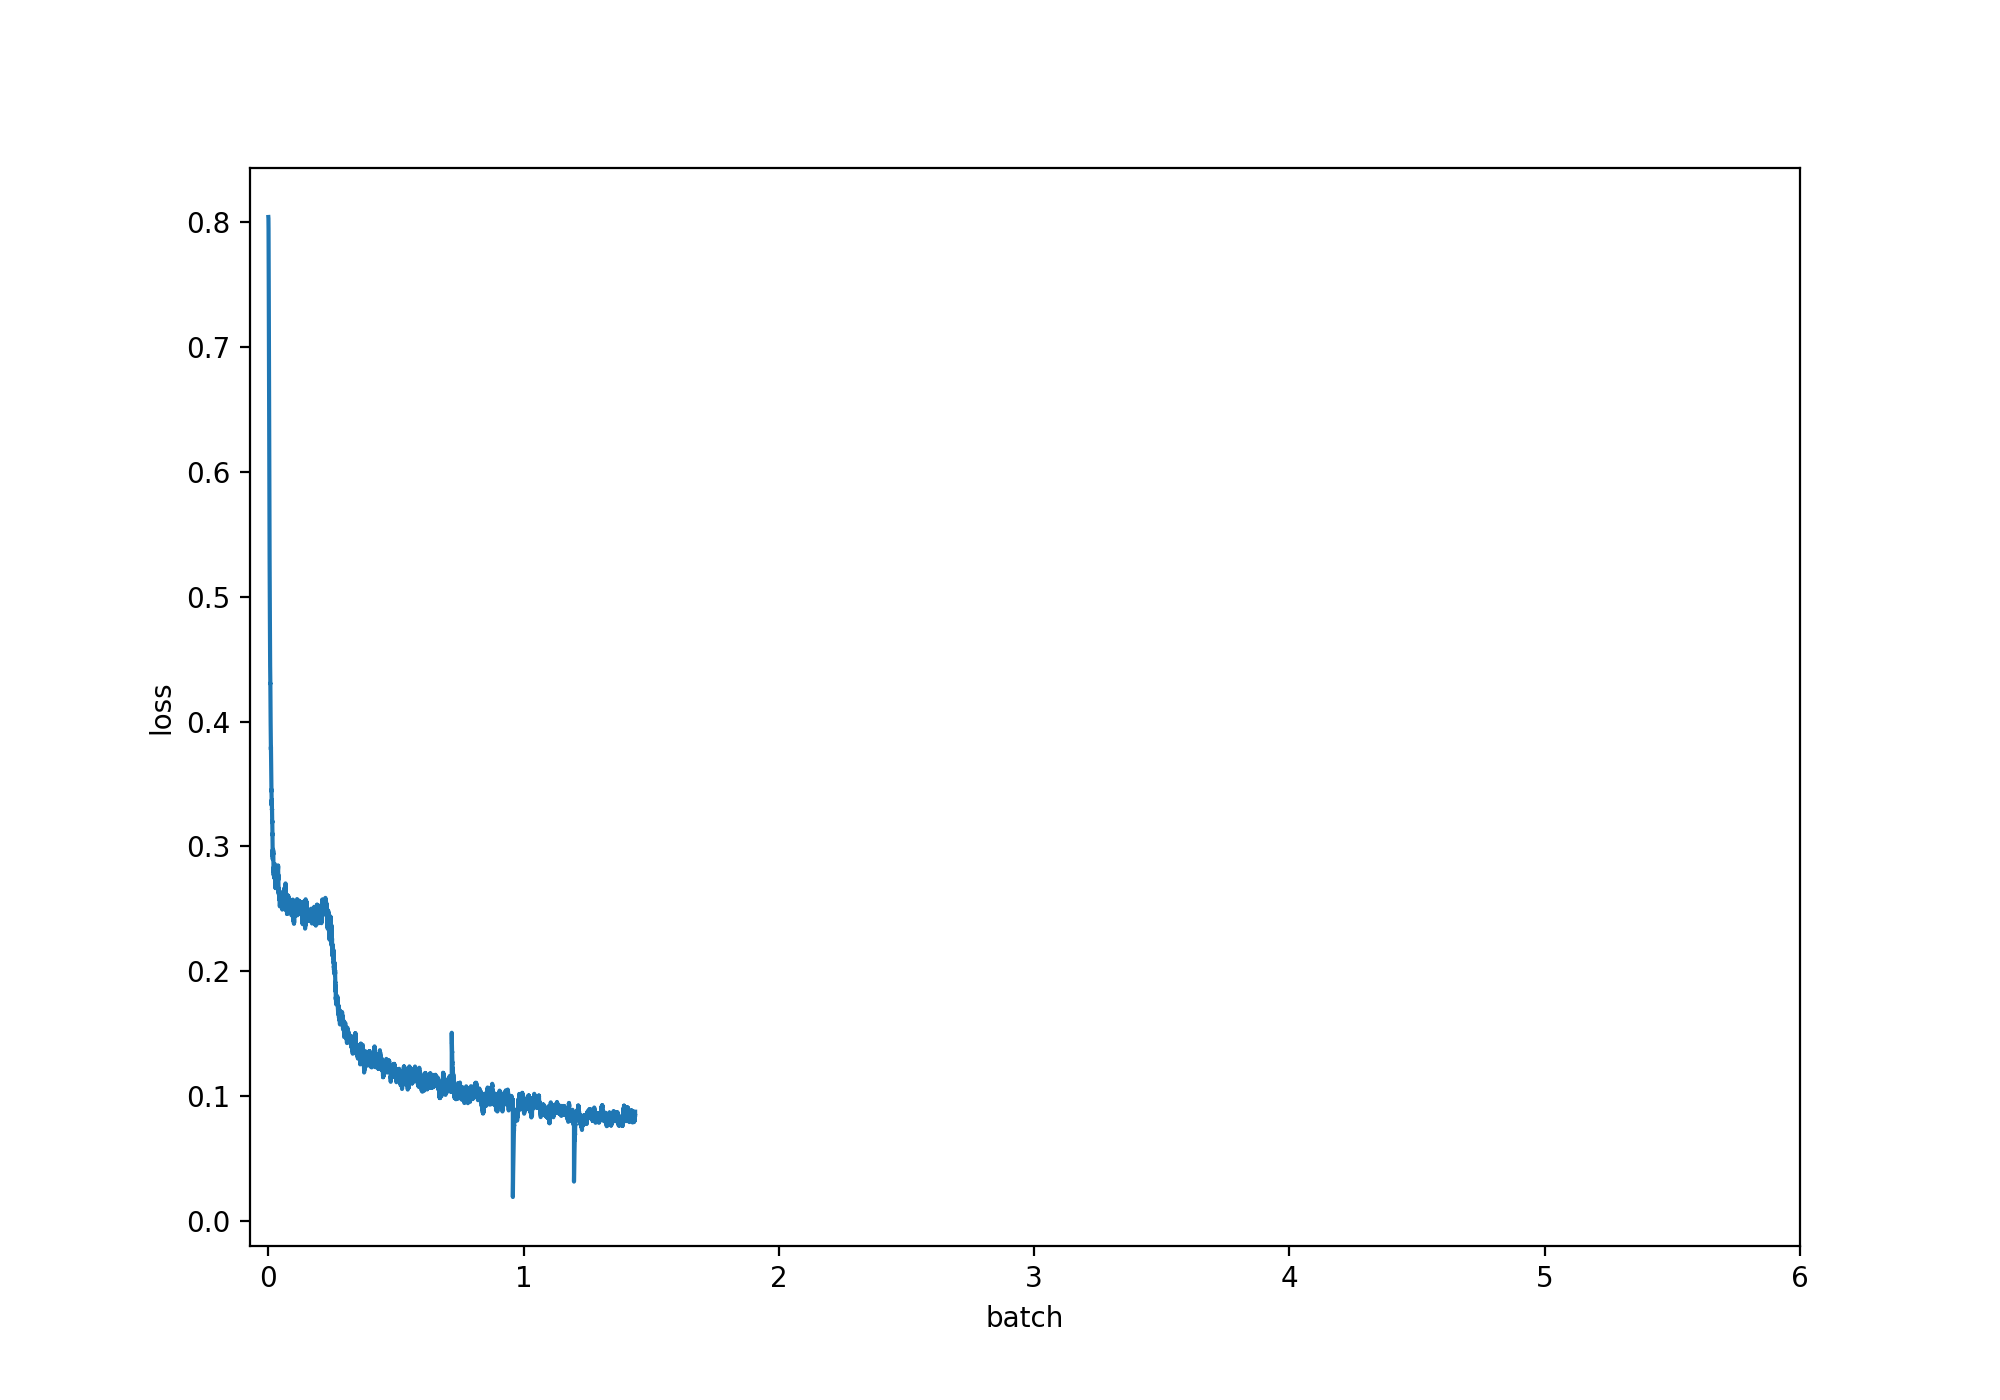

{'loss': 0.23853264965691676, 'val_loss': 0.21048164769975236}


{'loss': 0.08749159042731146, 'val_loss': 0.10008033753256106}

0.10008033753256106


In [10]:
%matplotlib nbagg
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=24
num_workers=12
num_epochs=6
model_name,version = 'efficientnet_5b5' , 'classifier1'
model = MyEfficientNet(ptcv_get_model("efficientnet_b5b", pretrained=True),len(hemorrhage_types),dropout=0.5)
#model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic1',num_split),map_location=torch.device(device)))
_=model.to(device)
param_s=parameter_scheduler(model,num_epoch=1)        
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.1,rotate=20,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[0.2,0.2,0.2,0.2,0.2,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//2,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=param_s,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [11]:
history

[{'loss': 0.23853264965691676, 'val_loss': 0.21048164769975236},
 {'loss': 0.11714664180128219, 'val_loss': 0.12524312680429017},
 {'loss': 0.10325279587022022, 'val_loss': 0.11019016826835827},
 {'loss': 0.09664503987658389, 'val_loss': 0.10511935364008594},
 {'loss': 0.08281671897778738, 'val_loss': 0.10558856802900653},
 {'loss': 0.08749159042731146, 'val_loss': 0.10008033753256106}]

In [12]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=24
num_workers=12
num_epochs=1
model_name,version = 'efficientnet_5b5' , 'basic1_classifier'
model = MyEfficientNet(ptcv_get_model("efficientnet_b5b", pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic1',num_split),map_location=torch.device(device)))
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
        
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

KeyboardInterrupt: 

In [ ]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=24
num_workers=12
num_epochs=1
model_name,version = 'efficientnet_5b5' , 'basic_classifier1'
model = MyEfficientNet(ptcv_get_model("efficientnet_b5b", pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
        
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [ ]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=12
num_epochs=2
model_name,version = 'se_resnext101_32x4d' , 'basic_more'
model = MySENet(pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained='imagenet'),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic_classifier',num_split),map_location=torch.device(device)))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*2,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [11]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=32
num_workers=12
num_epochs=1
model_name,version = 'Densenet161' , 'basic_more'
model1 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
    
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//1,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
huston is the an empty picture 470e639ae
huston is the an empty picture d91d52bdc
huston is the an empty picture 0e21abf7a
huston is the an empty picture 8da38f2e4


got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
{'loss': 0.011510233211503544, 'val_loss': 0.01142682346834119}

0.01142682346834119


In [11]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=32
num_workers=12
num_epochs=1
model_name,version = 'Densenet161' , 'basic_classifier'
model1 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
    
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//1,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
huston is the an empty picture 470e639ae
huston is the an empty picture d91d52bdc
huston is the an empty picture 0e21abf7a
huston is the an empty picture 8da38f2e4


got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
{'loss': 0.011510233211503544, 'val_loss': 0.01142682346834119}

0.01142682346834119


0.07998776427838833

In [10]:
sample_submission=pd.read_csv(data_dir+'stage_1_sample_submission.csv')
sample_submission.head()
test_df=sample_submission.copy()
test_df['Sub_type'] = test_df['ID'].str.split("_", n = 3, expand = True)[2]
test_df['PatientID'] = test_df['ID'].str.split("_", n = 3, expand = True)[1]
test_df.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


,ID,Label,Sub_type,PatientID
0,ID_28fbab7eb_epidural,0.5,epidural,28fbab7eb
1,ID_28fbab7eb_intraparenchymal,0.5,intraparenchymal,28fbab7eb
2,ID_28fbab7eb_intraventricular,0.5,intraventricular,28fbab7eb
3,ID_28fbab7eb_subarachnoid,0.5,subarachnoid,28fbab7eb
4,ID_28fbab7eb_subdural,0.5,subdural,28fbab7eb


In [11]:
test_Id_df = pd.DataFrame(data={'PatientID':test_df.PatientID.unique()})
test_Id_df.head()

,PatientID
0,28fbab7eb
1,877923b8b
2,a591477cb
3,42217c898
4,a130c4d2f


In [12]:
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic_more',num_split),map_location=torch.device(device)))
_=model.to(device)
imagedataset_test=ImageDataset(test_Id_df,transform=transform_val.random,base_path=test_images_dir)
pred = model_run(model,imagedataset_test,do_apex=True,batch_size=64,num_workers=12)

In [14]:
sub_num=5

epidural_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
subdural_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
any_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])})

test_res_df = pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).reset_index(drop=True)
trd=test_res_df.sort_values('ID')
sample_submission[['ID','Label']]=trd.values[np.argsort(np.argsort(sample_submission.ID.values))]
sample_submission.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])
sample_submission.head(10)

,ID,Label
0,ID_28fbab7eb_epidural,3.033406e-11
1,ID_28fbab7eb_intraparenchymal,6.375548e-07
2,ID_28fbab7eb_intraventricular,1.966767e-09
3,ID_28fbab7eb_subarachnoid,5.399497e-08
4,ID_28fbab7eb_subdural,1.490849e-07
5,ID_28fbab7eb_any,1.532611e-05
6,ID_877923b8b_epidural,4.363462e-09
7,ID_877923b8b_intraparenchymal,1.888572e-06
8,ID_877923b8b_intraventricular,4.644881e-09
9,ID_877923b8b_subarachnoid,8.013500e-06


In [17]:
submission_121=pd.read_csv('/media/hd/notebooks/data/RSNA/submissions/submission1.csv')

In [20]:
sample_submission.Label=(sample_submission.Label+submission_121.Label)/2
sample_submission.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.000001
1,ID_28fbab7eb_intraparenchymal,0.000016
2,ID_28fbab7eb_intraventricular,0.000003
3,ID_28fbab7eb_subarachnoid,0.000103
4,ID_28fbab7eb_subdural,0.000105


In [21]:
sub_num=4
sample_submission.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])
